# Autoencoder

In [1]:
%matplotlib inline

import warnings

import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

# warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
# tf.logging.set_verbosity(tf.logging.WARN)
# Reproducability
SEED = 0
tf.set_random_seed(SEED)
np.random.seed(SEED)

In [2]:
# @make_template as a function decorator for tf.make_template
make_template = lambda func: tf.make_template(func.__name__, func)

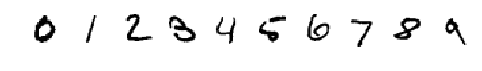

In [3]:
# Load data and plot examples
IMG_SHAPE = (28, 28)  # Shape of Mnist image
BATCH_SIZE = 64

# Load Mnist data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalise data so each pixel is between 0 and 1
x_train = x_train / 255.
x_test = x_test / 255.

# Tensorflow dataset iterator for training
train_batch = tf.data.Dataset.from_tensor_slices(x_train).shuffle(
    buffer_size=1000, seed=SEED
    ).repeat().batch(BATCH_SIZE).make_one_shot_iterator().get_next()

# Plot examples from test
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))
for i in range(10):
    axs[i].imshow(np.squeeze(x_test[np.argwhere(y_test==i)[0]]), cmap=cm.binary)
    axs[i].set_axis_off()
plt.show()

In [4]:
EMBEDDING_DIMS = 2  # Number of dimensions in latent embedding


@make_template
def encoder(x):
    """Variational distribution q(Z|X)"""
    net = tf.layers.flatten(x)
    net = tf.layers.dense(net, 256, tf.nn.relu)
    net = tf.layers.dense(net, 64, tf.nn.relu)
    return tf.layers.dense(net, EMBEDDING_DIMS)

In [5]:
@make_template
def decoder(z):
    """p(X|z)"""
    net = tf.layers.dense(z, 64, tf.nn.relu)
    net = tf.layers.dense(net, 256, tf.nn.relu)
    logit = tf.layers.dense(net, np.prod(IMG_SHAPE))
    logit = tf.reshape(logit, [-1, *IMG_SHAPE])
    return logit

In [6]:
# Model for training
# Input mnist images placeholder
x = tf.placeholder(tf.float32, shape=[None, *IMG_SHAPE])
x_embeddings = encoder(x)
logits = decoder(x_embeddings)
x_reconstruct = tf.nn.sigmoid(logits)
# For testing
z = tf.placeholder(tf.float32, shape=(None, 2))
x_z = tf.nn.sigmoid(decoder(z))

In [7]:
# Optimization
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=logits))
print('x: ', x.shape)
print('logits: ', logits.shape)
print('loss: ', loss.shape)
train_op = tf.train.AdamOptimizer(0.003).minimize(loss)

x:  (?, 28, 28)
logits:  (?, 28, 28)
loss:  ()


In [8]:
def gen_embedding_samples(x_embeddings_test, n):
    mean = np.mean(x_embeddings_test, axis=0)
    cov = np.cov(x_embeddings_test.T)
    z_samples = np.random.multivariate_normal(mean, cov, n)
    return z_samples

In [9]:
# Dictionary to store model results during training
test_iterations = dict.fromkeys(
    [0, 5, 10, 25, 100, 500, 1000, 10000, 25000, 50000])
# List to store training metrics for plotting
train_iterations = []
sess = tf.Session()
with sess.as_default():
    sess.run(tf.global_variables_initializer())
    for i in range(max(test_iterations.keys())+1):
        # Get evaluations from test set
        if i in test_iterations:
            loss_test, x_embeddings_test = sess.run(
                [loss, x_embeddings], 
                feed_dict={x: x_test.reshape([-1, *IMG_SHAPE])})
            z_samples = gen_embedding_samples(x_embeddings_test, n=5)
            x_z_test = sess.run(x_z, feed_dict={z: z_samples})
            test_iterations[i] = loss_test, x_embeddings_test, x_z_test
            print(f'Iteration {i: <5} loss: {loss_test:.2f}')
        # Run optimization while getting training metrics
        (loss_eval, _) = sess.run([loss, train_op], 
            feed_dict={x: train_batch.eval(session=sess)})
        # Save training metrics for plotting
        train_iterations.append(loss_eval)

Iteration 0     loss: 0.69
Iteration 5     loss: 0.38
Iteration 10    loss: 0.30
Iteration 25    loss: 0.27
Iteration 100   loss: 0.24
Iteration 500   loss: 0.20
Iteration 1000  loss: 0.19
Iteration 10000 loss: 0.17
Iteration 25000 loss: 0.17
Iteration 50000 loss: 0.17


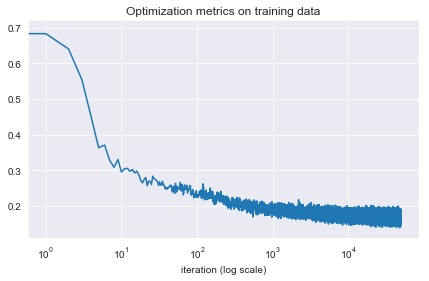

In [10]:
# Plot training graphs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
ax.set_xscale('log', nonposx='clip')
ax.set_xlabel('iteration (log scale)')
ax.set_title('Optimization metrics on training data')
ax.plot(train_iterations, label='loss')
plt.show()

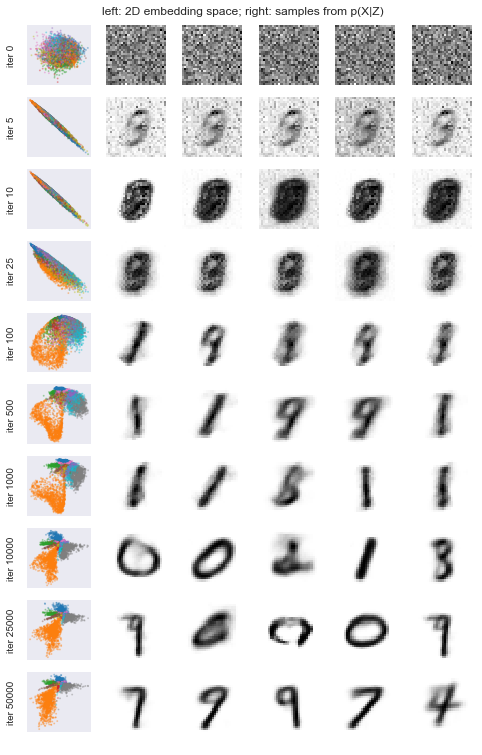

In [11]:
# Plot test embedding and decoded samples from prior
def plot_embeddings(ax, embeddings, labels):
    """Plot embedding points and color according to label."""
    with sns.axes_style('white'):
        ax.scatter(
            embeddings[:, 0], embeddings[:, 1], 
            s=1, c=labels, alpha=0.3, cmap=cm.tab10)
    sns.despine(ax=ax,top=True, right=True, left=True, bottom=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)

def plot_decoded_samples(ax, samples):
    """Show decoded image sample"""
    for idx, sample in enumerate(samples):
        ax[idx].imshow(sample, cmap=cm.binary)
        ax[idx].set_axis_off()

# Plot test embeddings and decode samples
fig, ax = plt.subplots(
    nrows=len(test_iterations), ncols=6, figsize=(8, 13))
fig.suptitle('left: 2D embedding space; right: samples from p(X|Z)', y=0.9)
for plot_idx, (i, val) in enumerate(test_iterations.items()):
    neg_elbo_test, z_test, x_samples_test = val
    plot_embeddings(ax[plot_idx, 0], z_test, y_test)
    plot_decoded_samples(ax[plot_idx, 1:], x_samples_test)
    ax[plot_idx, 0].set_ylabel(f'iter {i}')
plt.show()

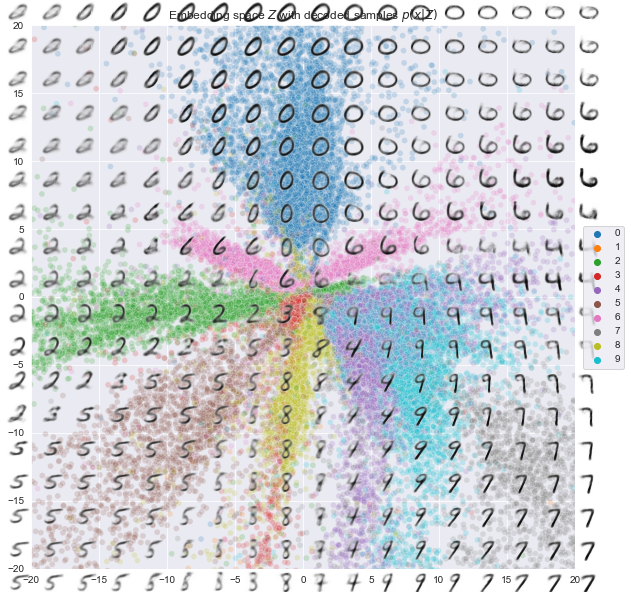

In [13]:
# Plot decoded samples from latent space on top of the latent space
# Combine training and testing data
x_all = np.vstack((x_train, x_test))
y_all = np.hstack((y_train, y_test))

# Plot limits
limits = (-20, 20)

# Get embedding points of all samples and get decodings along grid
with sess.as_default():
    # Embeddings of (x_train, x_test)
    embeddings = sess.run(
        x_embeddings, feed_dict={x: x_all.reshape([-1, *IMG_SHAPE])})
    # Embedding coordinates in grid
    z_grid_coords = np.asarray([
        (x, y) for x in np.linspace(limits[0]+0.5, limits[1]-0.5, num=18)
        for y in np.linspace(limits[0]+0.5, limits[1]-0.5, num=18)
    ])
    # Samples from encoder along `z_grid_coords`
    z_grid_samples = sess.run(x_z, feed_dict={z: z_grid_coords})

    
# Plot all embeddings with encoded samples on top
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sc = sns.scatterplot(
    x=embeddings[:, 0], y=embeddings[:, 1], hue=y_all,
    legend='full', palette=cm.tab10, alpha=0.2, ax=ax)
sc.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)
ax.set_aspect('equal', 'box')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title('Embedding space $Z$ with decoded samples $p(x|Z)$')

# Plot all encoded samples on top of the embedding space
#  (samples are plotted on their respective z-coordinates)
for i in range(z_grid_coords.shape[0]):
    # Create image with alpha channel
    img = Image.fromarray(np.uint8((1-z_grid_samples[i])*255))
    img = img.convert('RGB')
    img.putalpha(Image.fromarray(np.uint8((z_grid_samples[i])*255)))
    # Show image on plot
    img_plot = OffsetImage(img, cmap=cm.binary, zoom=1.0)
    img_plot.image.axes = ax
    ab = AnnotationBbox(
        img_plot, xy=(z_grid_coords[i,0], z_grid_coords[i,1]),
        xycoords='data',
        boxcoords='offset points',
        frameon=False)                                  
    ax.add_artist(ab)

plt.show()